<a href="https://colab.research.google.com/github/VaibhavR27/ece529/blob/main/Project_03_Rathore_Vaibhav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 529/629 - Project 3

# Name: ___Vaibhav Rathore___
## Traffic Sign Dataset

This dataset is from https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

**Please download the dataset from Kaggle to the datasets/traffic_signs folder before running this notebook.**

The import functions are from https://www.kaggle.com/akrsnv/gtsrb-classification-with-vgg-19

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import os
import cv2
import csv
import numpy as np
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import pathlib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical

import pandas as pd

The following shows the 43 classes of the dataset. The image is the idealized representation of the street sign.

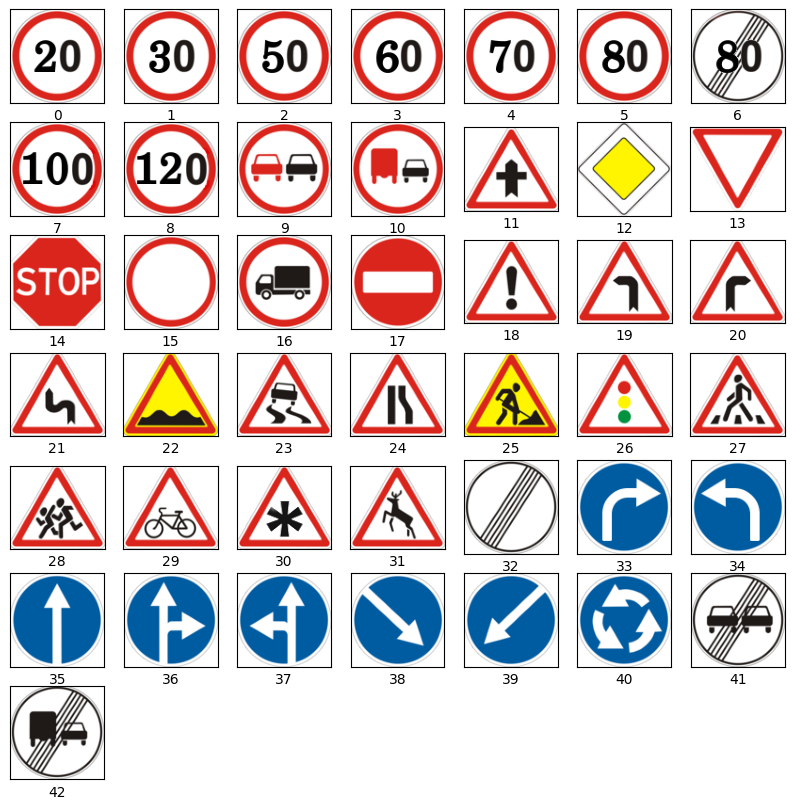

In [3]:
dir = './drive/MyDrive/traffic_signs_1'

plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = dir + "/Meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

The following code loads the dataset from disk into memory. In addition, the 3 color values of each image (red, green blue) are scaled to 0..1. The shape of each image is 50 x 50 with 3 color values. The classification data is represented with one-hot encoding.

In [4]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [5]:
train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

In [ ]:
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
y_train[0]

In [ ]:
plt.imshow(cv2.cvtColor(X_train[30000], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
y_train[30000]

## Part 1: Model Structure

The following code shows the configuration and training of a straightforward 3-layer model. You can reuse this code block throughout the assignment and simply change the various aspects under consideration.

**NOTE:** It is important that you clear the session whenever you train a different model to be able to compare them. Otherwise, Keras will continue training the model it has been working on, which might lead to confusing results.

Since training can take some time, we initially train with just a small number of epochs. You can adjust this variable as you like. Larger values will require more processing time. In Part 5, we will take our model and train for a long time.

In [ ]:
epochs = 5

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(50, activation="sigmoid"),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Change model to have more layers.

Change your model to have a wider layer.

Pick a model, and do not change the "shape" of it anymore in the steps below. Which model are you using?

Answer: _________

## Part 2: Activation Function

Using the model you selected in Part 1, try out three different activation functions (in addition to the sigmoid function that you already tried in Part 1). The Keras documentation lists the available activation functions: https://keras.io/api/layers/activations/ Please make sure to use activation functions that are appropriate for each layer. I.e., the softmax activation function for the final layer needs to remain unchanged and softmax should not be used inside the network.

Based on these results, which activation function do you choose to continue with?

Answer: _________

## Part 3: Batch Normalization

Add Batch Normalization to the model you chose in Part 2. Depending on your activation function, add the appropriate initialization.

Does batch normalization improve the validation accuracy for your model?

Answer: _________

## Part 4: Regularization

Apply two regularization techniques to your model.

Does batch regularization improve the validation accuracy for your model?

Answer: _________

## Part 5: Longer Training

Pick one of the models you have constructed above. Select the one that you think will be most accurate for the test data.

Increase the training to run over a large number of epochs (30 or more). Feel free to change the optimizer and learning rate for this part if you like (not required for this project). Plot the accuracy and validation accuray (and loss if you like).

## Part 6: Evaluation

Evaluate the model you have trained in Part 5 on the test data.

What is the final accuracy of your model?

Answer: _________

Please summarize the characteristics of your model:

- Number of layers:
- Number of nodes per layer:
- Initialization:
- Activation Function:
- Normalization:
- Regularization:
- Optimizer:

In the following table, summarize the validation accuracy and running time during training for the different steps you have taken in the project. For parts, where you tried different models/parameters, report the one that you continued to use in later parts.

| Model                                 | validation accuracy | running time (per step) |
| ------------------------------------- | ------------------- |------------------------ |
| Baseline model in Part 1 (50/43)      | x.xx %              | xxx ms                  |
| Your model in Part 1 (...)            | x.xx %              | xxx ms                  |
| Activation function in Part 2         | x.xx %              | xxx ms                  |
| Batch normalization in Part 3         | x.xx %              | xxx ms                  |
| Regularization in Part 4              | x.xx %              | xxx ms                  |

What do you observe about the running time when adding various features?

Answer: _________

Reflection: During this project, what worked as expected? Was there anything that surprised you? What did you learn?
    
Answer: _________